In [ ]:
!sudo apt-get update
!sudo apt-get install gfortran

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,984 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,765 kB]
Get:13 https://r2u.stat.illinois.edu/ubunt

In [ ]:
!gfortran

gfortran: fatal error: no input files
compilation terminated.


In [1]:
!git clone https://gitlab.com/kirianlab/reborn.git reborn_repo

Cloning into 'reborn_repo'...
remote: Enumerating objects: 25219, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25219 (delta 6), reused 0 (delta 0), pack-reused 25202 (from 1)
Receiving objects: 100% (25219/25219), 23.15 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% (18206/18206), done.


In [2]:
pip install denss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 3.2 MB/s eta 0:00:00


In [3]:
%cd reborn_repo
!pip install .
%cd ..

/content/reborn_repo
Processing /content/reborn_repo
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for reborn: filename=reborn-2025.2.11-cp311-cp311-linux_x86_64.whl size=55531 sha256=a5ab8929dd8f73752e898c1e7f7740b9c5cd0e75bb241232437e98e2703ef0c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1m18juaa/wheels/7e/91/c2/5a1b56e5cc5e0f069912903059046389e973f5021b5a86ec40
Successfully built reborn
/content


# Restart the kernel after 1st installation
## And then continue running

In [153]:
import sys
sys.path.append('/content/reborn_repo')
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
import matplotlib.tri as tri
import reborn
from reborn.external import denss
from scipy import constants
import matplotlib.patches as patches
from scipy.signal import ZoomFFT
plt.rcParams['font.family'] = 'serif'

In [155]:
pdb_filename = '2gtl.pdb'
url = f'https://files.rcsb.org/download/{pdb_filename}'
urllib.request.urlretrieve(url, pdb_filename)
e = denss.create_density_map(
    pdb_file=pdb_filename,
    solvent_contrast=True,
    create_bio_assembly=True,
    map_resolution=2e-10,
    map_oversampling=1.1,
    ignore_waters=False,
)

Looking up unique atomic volumes...
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. Calculating unique volume.
CMO:O not found in volumes dictionary. Calculating unique volume.
CMO:C not found in volumes dictionary. C

In [158]:
def zoomed_fft(e, dx, zoom_fac=8):
    f1, f2 = -N/(2*zoom_fac), N/(2*zoom_fac)  # Define zoomed frequency range
    transform = ZoomFFT(N, [f1,f2], N, fs=N)
    for axis in range(3):
        e = transform(e, axis=axis)
    zoomed_freqs = np.linspace(f1, f2, N+1)[:-1]/(dx*N)  # Define zoomed frequency axis for x
    return e, zoomed_freqs

def detector_to_reciprocal_ewald(detector_x, detector_y, wavelength, detector_distance):
    """
    Calculates reciprocal space coordinates considering the Ewald sphere.
    Args:
        detector_x: X-coordinate of the detector position.
        detector_y: Y-coordinate of the detector position.
        wavelength: X-ray wavelength in Angstroms.
        detector_distance: Distance from the interaction region to the detector in Angstroms.
    Returns:
        A tuple containing the reciprocal space coordinates (qx, qy, qz).
    """
    # Calculate the scattering vector magnitude
    q_magnitude = (4 * np.pi / wavelength) * np.sin(
        0.5 * np.arctan(np.sqrt(detector_x**2 + detector_y**2) / detector_distance)
    )
    # Calculate the scattering vector components
    qx = q_magnitude * (detector_x / np.sqrt(detector_x**2 + detector_y**2))
    qy = q_magnitude * (detector_y / np.sqrt(detector_x**2 + detector_y**2))
    qz = (2 * np.pi / wavelength) - np.sqrt((2 * np.pi / wavelength)**2 - qx**2 - qy**2)
    return qx, qy, qz

def makeJungFrau4MGeom(ax,shift=0):
  a, b = 5.856e-1,7.761e-1
  c, d = 9.313e-1,7.338e-1
  h, w = 116.452e-1, 59.69e-1
  hs = 3.457e-1
  points = np.array([[-a, b], [a, -b], [c, d], [-c, -d]])
  for p in points:
      x, y = p
      cw, ch = w, h
      if x >= 0 and y >= 0:  # Quadrant I
          ch = -h
      elif x < 0 and y < 0:  # Quadrant III
          cw = -w
      elif x >= 0 and y < 0:  # Quadrant IV
          ch = -h
          cw = -w
      rect = patches.Rectangle((x+shift, y), cw, ch, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      rect = patches.Rectangle((x+shift+cw+np.sign(cw)*hs, y), cw, ch, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

def computeBulkScattering(Thickness, pulse_energy,photon_energy,Zs,dPixel,q):
  # This script calculates photons per pixel given 0.0013 photons per pixel are
  # ascertained from following sheet and beam parameters (LY59 data)
  a = 0.009808379098945963
  b = 698025922.1287639
  c = 0.0012248216063012226
  ppp = a * np.exp(- (q / b) ** 2) + c # 0.000213 # expected photons per pixel
  Thickness0 = 25e-9 # nm sheet thickness
  pulse_energy0 = .24 * 1e-3  # in joules
  photon_energy0 = 7.07 * 1e3 * constants.eV  # 7keV in joules
  Zs0 = 0.57 # detector Distance in m
  dPixel0 = 75e-6 # 75um pixel size

  # scale photons per pixel to new parameters
  ppp*=Thickness/Thickness0
  ppp*=pulse_energy/pulse_energy0
  ppp*=photon_energy0/photon_energy
  ppp*=(Zs0/Zs)**2
  ppp*=(dPixel/dPixel0)**2

  return ppp

(166, 166, 166)


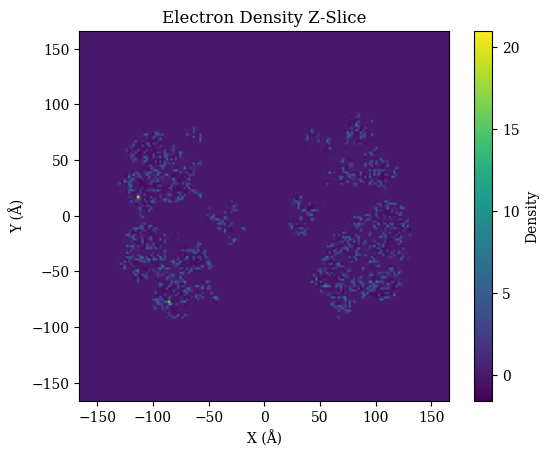

-1964209252.2593164 A^-1 to 1940544080.5453486 A^-1


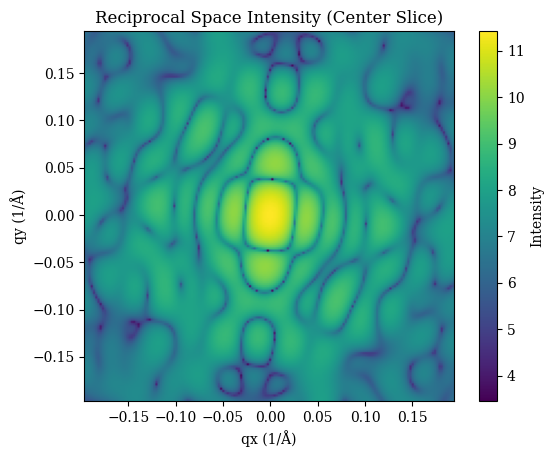

In [174]:
electronDensity = e[0]
N = electronDensity.shape[0]
print(electronDensity.shape)
side = e[1]
dx = side / electronDensity.shape[0]
extent = np.array([-dx * electronDensity.shape[1]/2, dx * electronDensity.shape[1]/2, -dx * electronDensity.shape[0]/2, dx * electronDensity.shape[0]/2])*1e10
plt.imshow(electronDensity[:,:,N//2], extent=extent)
plt.xlabel("X (Å)")
plt.ylabel("Y (Å)")
plt.title("Electron Density Z-Slice")
plt.colorbar(label="Density")
plt.show()

intensity, q = zoomed_fft(electronDensity, dx)
# Compute the 3D FFT

# Calculate reciprocal space coordinates
Nx, Ny, Nz = electronDensity.shape
qx = np.copy(q)*2*np.pi
qy = np.copy(q)*2*np.pi
qz = np.copy(q)*2*np.pi
print(qx.min(),'A^-1 to',qx.max(),'A^-1')
# Calculate intensity
intensity = np.abs(intensity)**2
interpolator = RegularGridInterpolator((qx,qy,qz), intensity, bounds_error=False, fill_value=0, method="linear")

# Select the center slice along the z-dimension
center_slice = intensity[:, :, intensity.shape[2] // 2]

# Create the extent for imshow using qx and qy ranges
extent = np.array([qx.min(), qx.max(), qy.min(), qy.max()])*1e-10

# Display the center slice with imshow
plt.imshow(np.log10(center_slice), extent=extent, origin='lower')

plt.xlabel("qx (1/Å)")
plt.ylabel("qy (1/Å)")
plt.title("Reciprocal Space Intensity (Center Slice)")
plt.colorbar(label="Intensity")
plt.show()

PhotonCount: 10^11.7
1598713488.3171165


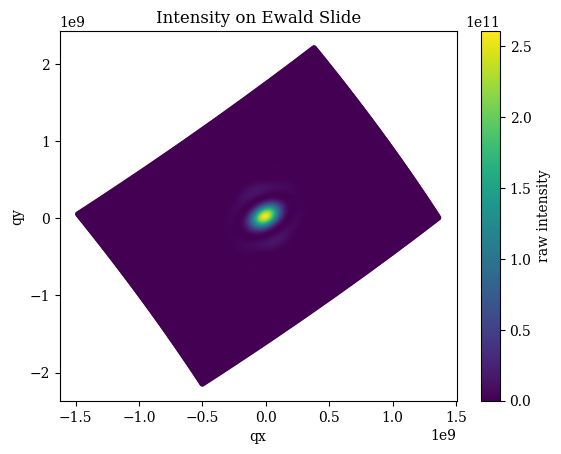

In [181]:
##### Constants ###########################################################
r_e = 2.8179 * 10**-15 # classical electron radii meters
hc = 1.9864e-25;  # m^3 kg/s^2
##### More Simulation Parameters ##########################################
photonEnergy = 6000*constants.eV
wavelength = hc/photonEnergy # Angstroms
Zd = .57  # m
pulseEnergy = .5e-3  # J
focus = 100e-9  # m
sheetThickness = 25e-9  # m
###########################################################################

photonCount = pulseEnergy/(hc/(wavelength))
print(f"PhotonCount: 10^{np.log10(photonCount):.1f}")
J_0 = photonCount/(np.pi/4*(focus)**2)

detector_x = np.linspace(-3e-2, 3e-2, 800)
detector_y = np.linspace(-3e-2, 3e-2, 800)
dPixel = detector_y[1]-detector_y[0]
detector_x, detector_y = np.meshgrid(detector_x, detector_y)

qx, qy, qz = detector_to_reciprocal_ewald(detector_x, detector_y,wavelength,Zd)
q = np.stack([qx, qy, qz], axis=-1)
print(q.max())
rotation_matrix, _ = np.linalg.qr(np.random.rand(3, 3))
q = np.einsum('ij,klj->kli', rotation_matrix, q) # rotate ewald sphere to random orientation using einstein notation
intensity = interpolator(q) # interpolate intensity on ewald sphere
fig = plt.figure()
ax = fig.add_subplot()
scatter = ax.scatter(q[::5, ::5, 0].ravel(), q[::5, ::5, 1].ravel(), marker='.', c=intensity[::5, ::5].ravel(), cmap=plt.cm.viridis)
ax.set_xlabel('qx')
ax.set_ylabel('qy')
cbar = plt.colorbar(scatter)
cbar.set_label('raw intensity')
ax.set_title('Intensity on Ewald Slide')
plt.show()

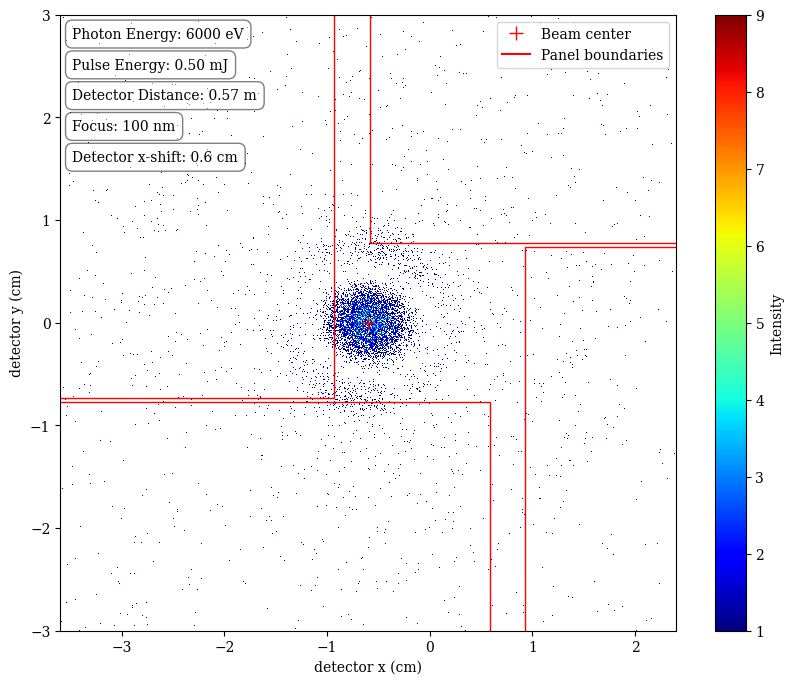

In [190]:
dOmega = dPixel**2/Zd**2*np.cos(np.atan(np.sqrt(detector_x**2+detector_y**2)/Zd)) # pixel solid angle
frame = J_0*r_e**2*dOmega*intensity + 0.5*computeBulkScattering(sheetThickness, pulseEnergy, photonEnergy,Zd,dPixel,np.sum(q**2,axis=2)**.5)
poisson_values = np.random.poisson(lam = frame)
poisson_values = poisson_values.astype(np.double)
poisson_values[poisson_values==0] = np.nan
shift = 0.6
extent = np.array([detector_x.min()-shift*1e-2, detector_x.max()-shift*1e-2, detector_y.min(), detector_y.max()])*100
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot() # Get the axes object
im = plt.imshow(poisson_values, extent=extent, origin='lower', interpolation='none', cmap='jet')
makeJungFrau4MGeom(ax)
plt.plot(-shift,0,'r+',label='Beam center',markersize=10)
plt.plot(10,10,'r-', label='Panel boundaries')
plt.xlabel("detector x (cm)")
plt.ylabel("detector y (cm)")
cbar = plt.colorbar(im, label="Intensity")
cbar.locator = plt.MaxNLocator(integer=True)
cbar.update_ticks()

ax.text(0.02, 0.98, f'Photon Energy: {photonEnergy/constants.eV:.0f} eV', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
ax.text(0.02, 0.93, f'Pulse Energy: {pulseEnergy*1e3:.2f} mJ', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
ax.text(0.02, 0.88, f'Detector Distance: {Zd:.2f} m', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
ax.text(0.02, 0.83, f'Focus: {focus*1e9:.0f} nm', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
ax.text(0.02, 0.78, f'Detector x-shift: {shift:.1f} cm', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
ax.axis(extent)
plt.legend()
plt.show()